# Loading Multilingual Sentence Matching Dataset

In [1]:
# !pip install fuzzywuzzy[speedup]
# !pip install transformers
# !pip install -U sentence-transformers
import json
import math
from sklearn.metrics import confusion_matrix
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.metrics import accuracy_score
import torch
from transformers import XLMRobertaModel
from transformers import XLMRobertaTokenizer
import matplotlib.pyplot as plt
import scipy


with open('../data/multilingual_sentence_matched_datasets.json') as f:
    sentence_pairs = json.load(f)
    
hindi_sentence_pairs = sentence_pairs['hindi_headlines']
spanish_sentence_pairs = sentence_pairs['ciper']
english_sentence_pairs = sentence_pairs['fact_pairs']

hindi_labels = [pair['label'] for pair in hindi_sentence_pairs]
spanish_labels = [pair['label'] for pair in spanish_sentence_pairs]
english_labels = [pair['label'] for pair in english_sentence_pairs]

print('Dataset loaded successfully.')

Dataset loaded successfully.


# Defining Utility Functions

In [15]:
def plot_accuracies(accuracies):
    x_values = range(1, 101)
    for accuracy_set in accuracies:
        plt.plot(x_values, accuracy_set['accuracies'], '-', label=accuracy_set['label'])
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()
    

def is_a_match(a, b, threshold):
    similarity = fuzz.partial_ratio(a, b)
    return similarity > threshold


def get_xlm_roberta_embeddings(text):
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0).to(device)
    outputs = model(input_ids)
    return torch.mean(outputs[0][0], dim=0)


# cosine = torch.nn.CosineSimilarity(dim=0)
from scipy.spatial.distance import cosine


def angdist(u,v):
    d=max(-1, min(1, cosine(u, v))) #Ensure d is strictly between -1 and 1
    return 1 - math.acos(1-d) / math.pi

# Similarity Matching Using Fuzzy String Matching

In [ ]:
hindi_predictions = [1 if is_a_match(pair['lookup_text'], pair['database_text'], 38) else 0 for pair in hindi_sentence_pairs]
spanish_predictions = [1 if is_a_match(pair['lookup_text'], pair['database_text'], 48) else 0 for pair in spanish_sentence_pairs]
english_predictions = [1 if is_a_match(pair['lookup_text'], pair['database_text'], 50) else 0 for pair in english_sentence_pairs]

print('Hindi accuracy: {}'.format(accuracy_score(hindi_predictions, hindi_labels)))
print('Spanish accuracy: {}'.format(accuracy_score(spanish_predictions, spanish_labels)))
print('English accuracy: {}'.format(accuracy_score(english_predictions, english_labels)))

# Generating Stats on Fuzzy String Matching Performance

In [ ]:
hindi_results = []
spanish_results = []
english_results = []
for threshold in range(1, 101):
    hindi_predictions = [1 if is_a_match(pair['lookup_text'], pair['database_text'], threshold) else 0 for pair in hindi_sentence_pairs]
    spanish_predictions = [1 if is_a_match(pair['lookup_text'], pair['database_text'], threshold) else 0 for pair in spanish_sentence_pairs]
    english_predictions = [1 if is_a_match(pair['lookup_text'], pair['database_text'], threshold) else 0 for pair in english_sentence_pairs]
    
    tn, fp, fn, tp = confusion_matrix(hindi_labels, hindi_predictions).ravel()
    hindi_results.append([tn, fp, fn, tp])
    tn, fp, fn, tp = confusion_matrix(spanish_labels, spanish_predictions).ravel()
    spanish_results.append([tn, fp, fn, tp])
    tn, fp, fn, tp = confusion_matrix(english_labels, english_predictions).ravel()
    english_results.append([tn, fp, fn, tp])
    
print('Stats generated successfully.')

In [ ]:
hindi_accuracies = [(res[0] + res[3])/(res[0] + res[1] + res[2] + res[3]) for res in hindi_results]
spanish_accuracies = [(res[0] + res[3])/(res[0] + res[1] + res[2] + res[3]) for res in spanish_results]
english_accuracies = [(res[0] + res[3])/(res[0] + res[1] + res[2] + res[3]) for res in english_results]

plot_accuracies([{'accuracies': hindi_accuracies, 'label': 'Hindi'}, {'accuracies': spanish_accuracies, 'label':'Spanish'}, {'accuracies': english_accuracies, 'label': 'English'}])

# Claim Matching Using XLM-R Embeddings

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("GPU name: {}, count: {}".format(torch.cuda.get_device_name(0), n_gpu))

model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=False)

if n_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = torch.nn.DataParallel(model)
model.cuda()
model.eval()

In [ ]:
# for i, pair in enumerate(hindi_sentence_pairs + spanish_sentence_pairs + english_sentence_pairs):
#     pair['lookup_text_embedding'] = get_xlm_roberta_embeddings(pair['lookup_text'])
#     pair['database_text_embedding'] = get_xlm_roberta_embeddings(pair['database_text'])
# print('Embeddings extracted successfully.')

hindi_results = []
spanish_results = []
english_results = []
for pair in hindi_sentence_pairs + spanish_sentence_pairs + english_sentence_pairs:
    pair['ang_distance'] = angdist(get_xlm_roberta_embeddings(pair['lookup_text']).detach().cpu().numpy(), get_xlm_roberta_embeddings(pair['database_text']).detach().cpu().numpy())

for threshold in range(1, 101):
    hindi_predictions = [1 if pair['ang_distance'] > threshold/100 else 0 for pair in hindi_sentence_pairs]
    spanish_predictions = [1 if pair['ang_distance'] > threshold/100 else 0 for pair in spanish_sentence_pairs]
    english_predictions = [1 if pair['ang_distance'] > threshold/100 else 0 for pair in english_sentence_pairs]

    tn, fp, fn, tp = confusion_matrix(hindi_labels, hindi_predictions).ravel()
    hindi_results.append([tn, fp, fn, tp])
    tn, fp, fn, tp = confusion_matrix(spanish_labels, spanish_predictions).ravel()
    spanish_results.append([tn, fp, fn, tp])
    tn, fp, fn, tp = confusion_matrix(english_labels, english_predictions).ravel()
    english_results.append([tn, fp, fn, tp])
    
print('Stats generated successfully.')

In [ ]:
hindi_accuracies = [(res[0] + res[3])/(res[0] + res[1] + res[2] + res[3]) for res in hindi_results]
spanish_accuracies = [(res[0] + res[3])/(res[0] + res[1] + res[2] + res[3]) for res in spanish_results]
english_accuracies = [(res[0] + res[3])/(res[0] + res[1] + res[2] + res[3]) for res in english_results]

plot_accuracies([{'accuracies': hindi_accuracies, 'label': 'Hindi'}, {'accuracies': spanish_accuracies, 'label':'Spanish'}, {'accuracies': english_accuracies, 'label': 'English'}])

# English Claims Matching Using Vanilla SBERT

In [17]:
from sentence_transformers import SentenceTransformer


sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

english_results_angdist = []
english_results_cosine = []

for pair in english_sentence_pairs:
    embeddings = sbert_model.encode([pair['lookup_text'], pair['database_text']])
    pair['ang_distance'] = angdist(embeddings[0], embeddings[1])
    pair['cosine_distance'] = cosine(embeddings[0], embeddings[1])

for threshold in range(1, 101):
    english_predictions_angdist = [1 if pair['ang_distance'] > threshold/100 else 0 for pair in english_sentence_pairs]
    english_predictions_cosine = [1 if pair['cosine_distance'] < threshold/100 else 0 for pair in english_sentence_pairs]

    tn, fp, fn, tp = confusion_matrix(english_labels, english_predictions_angdist).ravel()
    english_results_angdist.append([tn, fp, fn, tp])
    
    tn, fp, fn, tp = confusion_matrix(english_labels, english_predictions_cosine).ravel()
    english_results_cosine.append([tn, fp, fn, tp])
    
print('Stats generated successfully.')

Stats generated successfully.


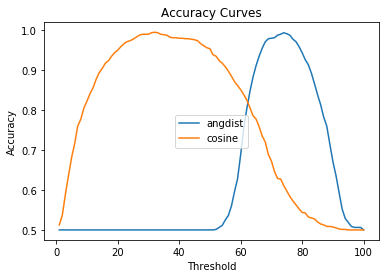

In [18]:
english_accuracies_angdist = [(res[0] + res[3])/(res[0] + res[1] + res[2] + res[3]) for res in english_results_angdist]
english_accuracies_cosine = [(res[0] + res[3])/(res[0] + res[1] + res[2] + res[3]) for res in english_results_cosine]

plot_accuracies([{'accuracies': english_accuracies_angdist, 'label': 'angdist'}, {'accuracies': english_accuracies_cosine, 'label':'cosine'}])

In [21]:
for result in english_results_cosine:
    print(result[0], result[1], result[2], result[3])

400 0 390 10
400 0 370 30
400 0 328 72
400 0 291 109
400 0 255 145
400 0 227 173
400 0 192 208
400 0 178 222
400 0 156 244
400 0 142 258
400 0 127 273
400 0 115 285
400 0 98 302
400 0 85 315
400 0 76 324
400 0 66 334
400 0 61 339
400 0 52 348
400 0 45 355
400 0 40 360
400 0 33 367
400 0 27 373
400 0 23 377
400 0 21 379
400 0 18 382
400 0 14 386
400 0 10 390
400 0 8 392
399 1 7 393
398 2 6 394
397 3 2 398
397 3 1 399
396 4 1 399
393 7 1 399
392 8 1 399
391 9 1 399
387 13 1 399
386 14 1 399
386 14 1 399
385 15 1 399
385 15 1 399
384 16 1 399
384 16 1 399
383 17 1 399
382 18 1 399
379 21 0 400
373 27 0 400
369 31 0 400
365 35 0 400
363 37 0 400
351 49 0 400
348 52 0 400
339 61 0 400
334 66 0 400
327 73 0 400
318 82 0 400
308 92 0 400
297 103 0 400
289 111 0 400
281 119 0 400
271 129 0 400
260 140 0 400
245 155 0 400
229 171 0 400
222 178 0 400
207 193 0 400
188 212 0 400
176 224 0 400
151 249 0 400
138 262 0 400
117 283 0 400
103 297 0 400
102 298 0 400
89 311 0 400
78 322 0 400
67 333 0 